In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from dataloader import get_data
from sklearn.model_selection import train_test_split

In [2]:
tf.test.is_gpu_available()

True

In [3]:
def angular_dist_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(tf.math.acos(tf.math.cos(y_pred[0]) * tf.math.cos(y_true[0]) + tf.math.sin(y_pred[0]) * tf.math.sin(y_true[0]) * tf.math.cos(y_pred[1] - y_true[1]))), axis=-1)

In [5]:
#model = tf.keras.Sequential()

# Todo: split up IC and DC strings!


# d1=16
# d2=16
# d3=16
# d4=16
# d5=16
# d6=128

d_lstm = 2

activation='relu'

#model.add(tf.keras.Input(shape=(N_channels, None, N_features)))#, ragged=True))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(d1, activation=activation, input_shape=(None, N_features)), input_shape=(N_channels, None, N_features)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d2, activation=activation), input_shape=(N_channels, d1)))

# without LSTM, simple sum over time

inputs = tf.keras.Input(shape=(N_channels, None, N_features))

h0 = tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(d_lstm, activation='relu', input_shape=(None, N_features)), input_shape=(N_channels, None, N_features), )(inputs)


#h0 = tf.keras.layers.Flatten(input_shape=(N_channels, 1))(inputs)
h1 = tf.keras.layers.Dropout(0.005)(h0)

h2 = tf.keras.layers.Reshape((86, 60 * d_lstm))(h1)

ic = tf.keras.layers.Lambda(lambda x: x[:, :78])(h2)
dc = tf.keras.layers.Lambda(lambda x: x[:, 78:])(h2)


h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu', input_shape=(60 * d_lstm,)), input_shape=(78,60 * d_lstm))(ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu', input_shape=(60 * d_lstm,)), input_shape=(8,60 * d_lstm))(dc)

h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu', input_shape=(16,)), input_shape=(78,16))(h_ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu', input_shape=(16,)), input_shape=(78,16))(h_dc)


h3 = tf.keras.layers.Concatenate(axis=1)([h_ic, h_dc])

h4 = tf.keras.layers.Flatten(input_shape=(86, 5))(h3)

h4 = tf.keras.layers.Dropout(0.001)(h4)

h5 = tf.keras.layers.Dense(16, activation='tanh')(h4)

outputs = tf.keras.layers.Dense(N_labels, activation='linear')(h5)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()


#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d1, activation=activation), input_shape=(N_channels, N_features)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d2, activation=activation), input_shape=(N_channels, d1)))
#model.add(tf.keras.layers.Reshape((86, 60 * d2)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d3, activation=activation, input_shape=(60*d2,)), input_shape=(86,60*d2)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d4, activation=activation, input_shape=(d3,)), input_shape=(86,d3)))
#model.add(tf.keras.layers.Flatten(input_shape=(86, d4)))
#model.add(tf.keras.layers.Dense(d5, activation='activation))
#model.add(tf.keras.layers.Dense(d6))



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5160, None,  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 5160, 2)      32          input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 5160, 2)      0           time_distributed[0][0]           
__________________________________________________________________________________________________
reshape (Reshape)               (None, 86, 120)      0           dropout[0][0]                    
______________________________________________________________________________________________

In [6]:
#optimizer = tf.keras.optimizers.RMSprop(0.05)
optimizer = tf.keras.optimizers.Adam(0.03, )
#optimizer='adam'

#model.compile(loss=angular_dist_loss, optimizer="sgd", )
model.compile(loss='mae', optimizer=optimizer)

In [4]:
X, y = get_data(
    '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000040.hdf5',
    features = ['charge'],
    labels = ['z'],
    sparse=False
    )

N_events, N_channels, _, N_features = X.shape
_, N_labels = y.shape

#X = np.sum(X, axis=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

max pulses =  242


In [ ]:
model.fit(X_train, y_train, batch_size=64, epochs=2, validation_data=(X_test, y_test),)

Train on 12301 samples, validate on 1367 samples
Epoch 1/2
10112/12301 [=======================>......] - ETA: 15s - loss: 97.9766

In [27]:
y_pred = model.predict(X_test, batch_size=64)

In [28]:
err = y_pred - y_test

In [29]:
np.sqrt(np.average(np.square(err), axis=0))

array([114.38161], dtype=float32)

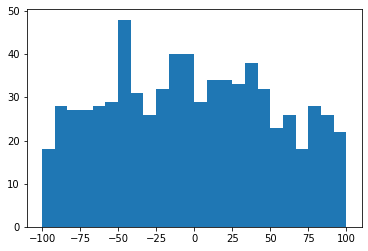

In [30]:
plt.hist(err, bins=np.linspace(-100,100,25));

In [31]:
np.quantile(err, [0.25, 0.5, 0.75])

array([-98.28393555,  -6.86242676,  88.77275085])

In [789]:
angular_dist_loss(y, y_pred)

<tf.Tensor: id=665976, shape=(), dtype=float32, numpy=2.3851235>

In [790]:
angular_dist_loss(y_train[::-1], y_train)

<tf.Tensor: id=665994, shape=(), dtype=float32, numpy=0.7891493>

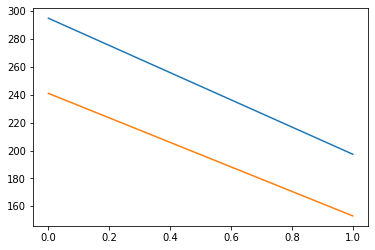

In [13]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])